# Hypothesis Testing

## Acknowledgment 

Some of the content here is based on [Computational and Inferential Thinking: The Foundations of Data Science](https://inferentialthinking.com/chapters/intro.html), by A. Adhikari, J. DeNero, D. Wagner.

On the other hand, this text uses its own module `datascience` for data frame manipulations, while we will use pandas, which is the most commonly used library for data frames in Python.

## Importing Modules

Let's start by importing the necessary modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)  # default figure size
plt.style.use("ggplot")  # style sheet

## Introduction

Probability theory allows us to determine how likely some event can be.  For instance, the likelihood that I roll three sixes in a row with a (fair, regular 6-faced) die is $1$ in $6^3 = 216$, or about $0.46\%$.  So, although it can happen, we can see it is not very likely, and it will likely not happen often.

In cases where the probabilities are hard to compute, we can use Python to obtain [empirical probabilities](https://en.wikipedia.org/wiki/Empirical_probability): we simulate the event many times over, and find the proportion of times that we succeeded.  If the number of repetitions is large enough, the proportion of times the event occurred in our simulation is close to the theoretical probability that the even occurs.  (This is a consequence of the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).)

For instance, suppose we want to test if a dice is fair.  We can record a set of, say, 500 rolls of this die, and then compute the probability that we would get the observed results (or some particular *statistic* for the observed results) *under the assumption that the die was fair*.  If this probability is low, we would have reason to believe that the die is not fair.

(A *statistic* is just some numerical value associated to the data, like the average, median, maximum, etc.)

In practice, we can compute this probability empirically: we simulate rolling a fair a large number of times, and then see how often the particular observed statistic, or something "more extreme" value for it, occurs in our simulation.

## Testing Die For Bias Toward Sixes

Let's investigate the example above. Suppose that rolling some die 500 times, we got the following frequency for each face (in order, from 1 to 6):

In [2]:
observed_freq = np.array([79, 76, 85, 82, 79, 99])

Since the number of sixes seems a bit high (we expected about 83 sixes), we might be suspicious that the die in question yields six too often.  The questions is how likely it is that this extra number of sixes occurred simply due to the randomness of the process of rolling a die, versus the die really being biased towards six.

### Null Hypothesis

So, we have two hypotheses here:

* **Null hypothesis:** The die is not biased.
* **Alternative Hypothesis:** The die is biased toward sixes.

The term [*Null Hypothesis*](https://en.wikipedia.org/wiki/Null_hypothesis) is used to described the assumption that the difference between the observed values differs from the random model *simply due to the randomness*.  

Note that the alternative here is more specific than simply that our null hypothesis is false, as we have a particular way in which we are assuming the null hypothesis is false.  This will affect how we draw our conclusion.

We will then focus then on the number of sixes.  (This is our statistic for this test.)

So, let's investigate this by simulating 500 rolls of a fair die and counting the number of sixes:

In [3]:
def sixes_500_rolls():
    """
    Simulate rolling a die 500 times and returns the number of sixes obtained.
    
    INPUT:
    None.
    
    OUTPUT:
    Number of sixes from a simulation of rolling a die 500 times.
    """
    rolls = np.random.randint(1, 7, 500)
    return np.count_nonzero(rolls == 6)

Now we need to simulate this *a large number of times* and collect the data.  This will help us analyze how likely it is we get 99 sixes due simply to the randomness of the process: we just check how many times we obtained 99 sixes *or more* in our simulation!

In [4]:
%%time
number_of_repetitions = 10_000

# initialize array with zeros
rolls = np.zeros(number_of_repetitions, dtype=np.int16)

# repeat the experiment
for i in range(number_of_repetitions):
    rolls[i] = sixes_500_rolls()  # add roll to results

CPU times: user 59.5 ms, sys: 94 µs, total: 59.6 ms
Wall time: 59.4 ms


#### Technical Digression: Leveraging the Power of NumPy

The experiment above runs fast enough, but there is a more efficient way.  `np.random.randint` cat take a tuple for its size.

To make the numbers smaller, let's say we want repeat rolling a die 3 times (instead of 500) ten times (instead of 10,000).  We can do:

In [5]:
small_rolls = np.random.randint(1, 7, (10, 3))

small_rolls

array([[4, 5, 6],
       [2, 6, 6],
       [6, 2, 6],
       [3, 4, 2],
       [4, 2, 4],
       [3, 6, 4],
       [5, 4, 1],
       [5, 2, 1],
       [5, 1, 6],
       [4, 3, 5]])

Then, to get the number of sixes, we pass the optional argument `axis=1` to `np.count_nonzero`, so that it counts the number of sixes  *on rows*:

In [6]:
np.count_nonzero(small_rolls == 6, axis=1)

array([1, 2, 2, 0, 0, 1, 0, 0, 1, 0])

Thus, we could do the computation above simply with:

In [7]:
%%time
number_of_repetitions = 10_000

rolls = np.count_nonzero(
    np.random.randint(1, 7, (number_of_repetitions, 500)) == 6, 
    axis=1
)

CPU times: user 24.6 ms, sys: 6.23 ms, total: 30.8 ms
Wall time: 30.8 ms


(Note that the function `sixes_500_rolls` is not needed.)

In my experiments, this new version runs in about half the time.  In this case, either way the code is so fast that it might not be worth implementing this second method, as the first is probably easier to read (and write).  (*Readability counts!*)  But if your code is slow, it is worth considering using NumPy more directly in the computations.

**Back to our problem:** Let's see how many times we obtained 99 or more:

In [8]:
np.count_nonzero(rolls >= 99)

370

That is a "large" number, but remember, we repeated the process *many times*.  It is better then to actually see the proportion:

In [9]:
np.count_nonzero(rolls >= 99) / number_of_repetitions

0.037

It occurred about $3.675\%$ of the time.  (This percentage varies each time you run the code, but should not be too far off.)

Note that this basically saying that the probability of obtaining 99 or more sixes in 500 rolls of a fair die is about $3.675\%$.

### $p$-Value

This percentage is what we call the [*$p$-value*](https://en.wikipedia.org/wiki/P-value) of the test, meaning, the probability of obtaining test results at least as extreme as the result actually observed, under the assumption that the null hypothesis is correct.

Here, *more extreme* means to have even more sixes.  So, "more extreme" means that we would more inclined in accepting the *alternative* hypothesis.  Hence, its meaning depends on the context.

It is clear then that the observed number of sixes, i.e., 99, *could* occur.  But the probability of it occurring is about $3.75\%$.  So, do we reject or accept the alternative hypothesis (that the die is biased toward sixes)?

There are no fast rules, but there are two commonly used values:

* A $p$-value of $5\%$ or less is called *statistically significant*.
* A $p$-value of $1\%$ or less is called *highly statistically significant*.

It is usual to accept the alternative hypothesis if the $p$-values is statistically significant, or if we are more cautious, if it is *highly* statistically significant.


### Computing Significant Values (`np.percentile`)

To find what value would give a $p$-value of $5\%$, we need to find a value (number of sixes) such that only $5\%$ of our data has that many *or more* sixes.  (We have "*or more*" here because more sixes supports the alternative hypotheses.  In some cases, we might need "or less" instead!)

We can find this value using `np.percentile`: the [$k$-th percentile](https://en.wikipedia.org/wiki/Percentile) is the value in our data for which $k\%$ of all values are *below* it.

Since we want $5\%$ of values above it, this means that we have (about) $95\%$ below it.  So, we need the $95$-th percentile:

In [10]:
significant = np.percentile(rolls, 95)  # value for significant
significant

97.0

Similarly, for *highly* statistically significant, we need $1\%$ of the values to be equal or above it, so we need the $99$-th percentile:

In [11]:
highly_significant = np.percentile(rolls, 99)  # value for highly significant
highly_significant

103.0

### Visualization

Let's visualize our data with these values:

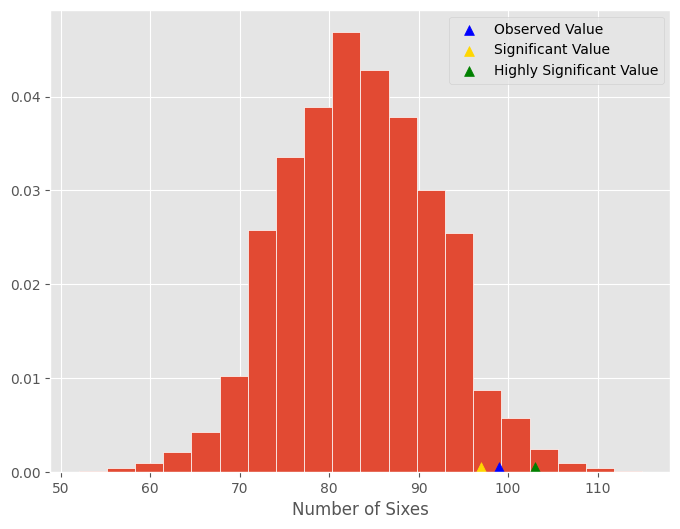

In [12]:
# distribution of number of sixes
plt.hist(rolls, density=True, ec="white", bins=20)

# observed value
plt.scatter(observed_freq[-1], 0, c="blue", marker="^", s=200, label="Observed Value")

# significant significant value
plt.scatter(significant, 0, c="gold", marker="^", s=200, label="Significant Value")

# highly significant value
plt.scatter(highly_significant, 0, c="green", marker="^", s=200, label="Highly Significant Value")

plt.xlabel("Number of Sixes")

plt.legend(markerscale=0.5);

In blue you see our observed number of sixes, and yellow and green you see the boundaries for statistically significant and highly statistically significant, respectively, number of sixes.

The usual convention is to accept the alternative hypothesis if the $p$-value is statistically significant, of more conservatively, if highly statistically significant.

Thus, we might be inclined in this case to accept the alternative hypothesis that *the die is biased towards sixes*.

**In any research or analysis, the actual $p$-value should be made available,** allowing the audience to draw their own conclusions.

Again, note that rejecting the alternative hypothesis does not guarantee that the die was actually biases, as we've see that it *could have occurred*!

### Actual Probability

In this case, it is not hard to compute the actual probability of rolling $99$ or more sixes in $500$ rolls of a fair die.  It is:

$$
1 - \sum_{i=0}^{98} \binom{500}{i} \left( \frac{1}{6} \right)^{i} \left( \frac{5}{6} \right)^{500 - i}  \approx 0.03657.
$$

Here is the computation using [SciPy](https://scipy.org/) (and NumPy), which provides the [binomial coefficients](https://en.wikipedia.org/wiki/Binomial_coefficient).

Note that SciPy does not come with Python, so it needs to be installed separately.  If you have a *vanilla* installation of Python, you can do it by running 

```
pip install scipy
```

from a terminal.

On the other hand, if you installed Anaconda, it should already be available.

In [13]:
# import the function comb for the binomial coefficients:
from scipy.special import comb

1 - np.sum(
    comb(500, np.arange(99))
    * ((5 / 6) ** np.arange(500, 500 - 99, -1))
    * ((1 / 6) ** np.arange(0, 99))
)

0.03657020131035571

On the other hand, in most situations the actual probability can be extremely hard to compute and, as we could see from this example, the empirical probability is usually quite close and easier to compute.

## Biased Die

Now assume that rolling the die 500 times we obtained the following distribution:


In [14]:
observed_freq = np.array([75, 97, 74, 62, 96, 96])

The distribution of values seems strange, with some number low and some numbers high. 

How could we investigate if it is biased in *any* way?  So our hypothesis in this case are:

* **Null hypothesis:** The die is not biased.
* **Alternative Hypothesis:** The die is biased.

So, we are not specifying a specific way in which the die is biased.  This affects how we will measure this bias.  What *statistic* (i.e., what aspect of the data) will we use to compare the given data with the simulations?

### Total Variation Distance (TVD)

One possibility is to use the *total variation distance* (TVD) between the roll proportions of the values in a roll and the expected proportions.

We expect the proportions to be all (about) $1/6 \approx 0.1667$.  Let's find the proportions we've found:

In [15]:
observed_prop = observed_freq / 500

observed_prop

array([0.15 , 0.194, 0.148, 0.124, 0.192, 0.192])

Let's see what are the differences (to see how much variation from the expected values we obtained):

In [16]:
expected_prop = np.array(6 * [1 / 6])

observed_prop - expected_prop

array([-0.01666667,  0.02733333, -0.01866667, -0.04266667,  0.02533333,
        0.02533333])

Since the proportions must add to $1$, the positives differences (frequencies higher than expected) and negative differences (frequencies lower than expected) cancel each other out:

In [17]:
np.sum(observed_prop - expected_prop)

5.551115123125783e-17

(Note the number above is *very* close to zero, and not zero due to approximations in floats!)

But, if we add the *absolute values* of these difference, and divide by $2$, we get a number that tell us what was *the variation that occurred both up and down*:

In [18]:
observed_tvd = np.sum(np.abs(observed_prop - expected_prop)) / 2

observed_tvd

0.07800000000000001

This number (half of the sum of the absolute values of the difference between observed and expected proportions) is the *total variation distance (TVD)* between the observed proportion and the expected.

As you can see, the TVD is useful when we have more than a single number we want to compare.

So, let's create now a function that computes the tvd between two arrays:

In [19]:
def tvd(array1, array2):
    """
    Computes the TVD of two arrays.
    
    INPUTS:
    array1: array;
    array2: array.
    
    OUTPUT:
    TVD between the two arrays.
    """
    return np.sum(np.abs(array1 - array2)) / 2

If we apply it to our observed and expected proportions, we should get the same number as above:

In [20]:
tvd(observed_prop, expected_prop)

0.07800000000000001

Now, let's write a function that rolls a die 500 times and get the TVD between the obtained and the expected proportions:

In [21]:
# The code below assumes we get each face (1, 2,... 6) at least once!
# But 500 is large enough that it would be *very* unlikely for it not to happen.

def tvd_500():
    """
    Simulates rolling a die 500 and computes the TVD between the proportions of each face and the expected
    proportions from a fair die.
    
    INPUT:
    None.
    
    OUTPUT:
    TVD between the proportions of each face and the expected proportion from a fair die.
    """
    _, freq = np.unique(np.random.randint(1, 7, 500), return_counts=True)
    prop = freq / 500
    return tvd(prop, expected_prop)

**Note:** `np.unique(array)` returns the unique values that appear in `array` *sorted*.  The optional argument `return_counts=True` adds a second output, with the count for each value (in the same order).  

So, in the code above, `freq` is an array with the numbers of times each face occurred (in order).  We can discard the first output (the actual values, i.e., `[1, 2, 3, 4, 5, 6]`), since we don't need it. 

We can now repeat this computation a large number of times, and see where our observed TVD sits within this data:

In [22]:
number_of_repetitions = 10_000

# initialize results
tvds = np.zeros(number_of_repetitions)

for i in range(number_of_repetitions):
    tvds[i] = tvd_500()  # add new TVD to array of results

In this case, *large* TVDs indicate large deviations from the expected values, so they support the alternative hypothesis.  Thus, to find the $p$-value, we see the proportion of TVDs larger than or equal to the observed one:

In [23]:
p_value = np.count_nonzero(tvds >= observed_tvd) / len(tvds)
p_value

0.0045

The actual $p$-value you get will vary, due to randomness, but in my experiments, it was always below $1\%$, so the observed TVD value is highly statistically significant.  

Thus, we would accept the alternative hypothesis, and conclude that *the die is not fair*.

### Visualization

Let's visualize the data in this case:

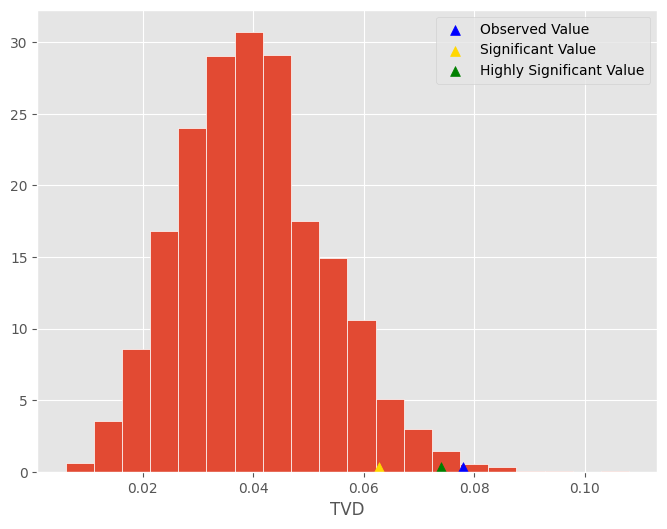

In [24]:
# distribution of number of sixes
plt.hist(tvds, density=True, ec="white", bins=20)

# significant values
significant = np.quantile(tvds, 0.95)  # value for significant
highly_significant = np.quantile(tvds, 0.99)  # value for highly significant

# observed value
plt.scatter(observed_tvd, 0, c="blue", marker="^", s=200, label="Observed Value")

# significant value
plt.scatter(significant, 0, c="gold", marker="^", s=200, label="Significant Value")

# highly significant value
plt.scatter(highly_significant, 0, c="green", marker="^", s=200, label="Highly Significant Value")

plt.xlabel("TVD")

plt.legend(markerscale=0.5);

## Robert Swain's Case

Robert Swain was indicted and convicted for rape in 1962, in Talladega County, Alabama.  He [appealed his indictment](https://en.wikipedia.org/wiki/Swain_v._Alabama) on the grounds that Black people were systematically excluded from juries in Talladega County.

Even though 26% of the eligible jurors in the county were black, in his panel (from which the jury is supposed to be selected) only 8% of them were black.   (The jurors were selected from a panel of people *who were supposed to be representative of the population of eligible jurors*.)

But the U.S. Supreme Court reviewed the appeal and concluded:

> "the overall percentage disparity has been small." 

So, here we have:

* **Null Hypothesis:** There was no bias in the jury selection.  (The difference to the expected value was due only to the randomness of the draw.)
* **Alternative Hypothesis:** There were too few blacks in the panel.

As, with the previous examples, we can test if a panel with 8% of blacks is reasonable, by simulating the drawing of 100 jurors for the panel from a population that is 26% black.  We can repeat this many times and see how often we obtained 8% or less black jurors.

The following function allows us to simulate the drawing of the panel from the population.  It takes an array of proportions (or probabilities) and a number of samples, and returns the obtained proportions from a random sample of the given size, drawn randomly:

In [25]:
def sample_proportions(sample_size, proportions_array):
    """
    Given an array of proportions/probabilities for categories for a random draw and a sample size,
    randomly draws a sample with sample_size elements with the given proababilities for each 
    category, and returns the obtained proportions of elements in each categoy.
    
    INPUTS:
    sample_size: number of elements to be randonly drawn from the population;
    proportions_array: an array with the proportions for each category in the population.
    
    OUTPUT:
    An array with the proportions in the random sample.
    
    """
    # number of categories
    num_bins = len(proportions_array)
    
    # initialize the result
    results = np.zeros(num_bins, dtype=float)

    # samples
    sample_array = np.random.random(sample_size)
    
    # categories cut-offs
    csum = np.append(np.array([0]), np.cumsum(proportions_array))
    
    # check for each category
    for i in range(num_bins):
        results[i] = np.count_nonzero((sample_array >= csum[i]) & (sample_array <  csum[i+1]))

    return results / sample_size

We can use this function now to simulate drawing a random sample from the population of the county, with the given breakdown between blacks and whites.

In [26]:
sample_size = 100
eligible_population = [0.26, 0.74]

Each time we run this function, we get the proportions of blacks and whites, respectively, from our random draw of 100:

In [27]:
sample_proportions(sample_size, eligible_population)

array([0.33, 0.67])

We will use the proportion of black individuals in the panel as our statistic.  In Swain's panel, this proportion was 0.08:

In [28]:
observed_prop = 0.08

Now, draw 20,000 random panels of 100 from the population:

In [29]:
number_of_repetitions = 20_000

# initialize results as zeros
props = np.zeros(number_of_repetitions)

# repeat the draws
for i in range(number_of_repetitions):
    props[i] = sample_proportions(100, eligible_population)[0]  # add to results

Now, we find the $p$-value for the observed proportion:

In [30]:
np.count_nonzero(props <= 0.08) / len(props)

0.0

The proportion seems to be $0$!  So, in 20,000 draws, we *never* got 8% of blacks or less (when drawing from a population that is $26\%$ black)!  So, the $p$-value is $0$ here, and we should *definitely* accept the alternative hypothesis that the selection process *was biased against blacks*.

Let's find the proportions that give us statistically significant and highly statistically significant $p$-values.

Note that since in this case *smaller* values support the alternative hypothesis, we need to take the *fifth and first percentiles* (and not the $95$-th and $99$-th, as in the previous examples where *larger* values supported the alternative hypothesis).

In [31]:
significant = np.percentile(props, 5)
highly_significant = np.percentile(props, 1)

print(f"Statistically significant:        {significant:.2f}")
print(f"Highly statistically significant: {highly_significant:.2f}")

Statistically significant:        0.19
Highly statistically significant: 0.16


Here is the plot:

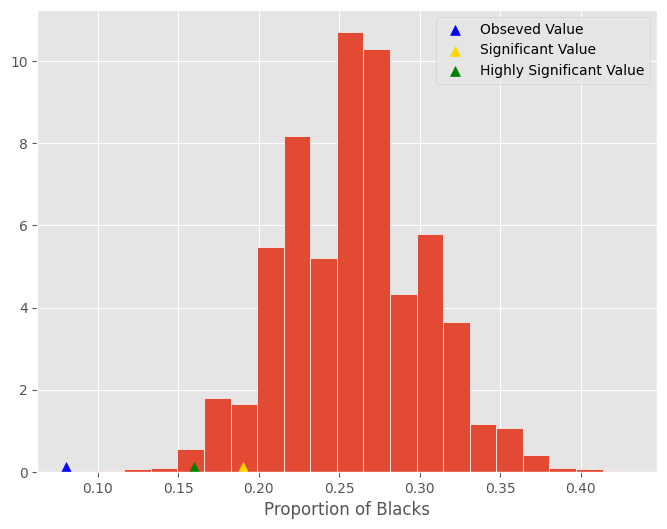

In [32]:
# distribution of proportions of blacks
plt.hist(props, density=True, ec="white", bins=20)

# observed value
plt.scatter(observed_prop, 0, c="blue", marker="^", s=200, label="Obseved Value")  # observed value

# significant value
plt.scatter(significant, 0, c="gold", marker="^", s=200, label="Significant Value")

# highly significant value
plt.scatter(highly_significant, 0, c="green", marker="^", s=200, label="Highly Significant Value")

plt.xlabel("Proportion of Blacks")

plt.legend(markerscale=0.5);

### Increase Number of Repetitions

Maybe, increasing the number of repetitions, we can see if $8\%$ can occur.  Let's do *100,000* repetitions:

In [33]:
number_of_repetitions = 100_000

# initialize with zeros
props100K = np.zeros(number_of_repetitions)

for i in range(number_of_repetitions):
    # add one proportion
    props100K[i] = sample_proportions(100, eligible_population)[0]

Let's check what was the smallest proportion of blacks in all draws:

In [34]:
np.min(props100K)

0.09

Although it got closer, even with 100,000 draws, we never got $8\%$ (or less), so the $p$-value remains $0$.

Let's see if the increased number of repetitions changes the significant values:

In [35]:
significant100K = np.percentile(props100K, 5)
highly_significant100K = np.percentile(props100K, 1)

print(f"Statistically significant:        {significant:.2f}")
print(f"Highly statistically significant: {highly_significant:.2f}")

Statistically significant:        0.19
Highly statistically significant: 0.16


As you can observe, these values don't change much.  Let's see if the histogram changes:

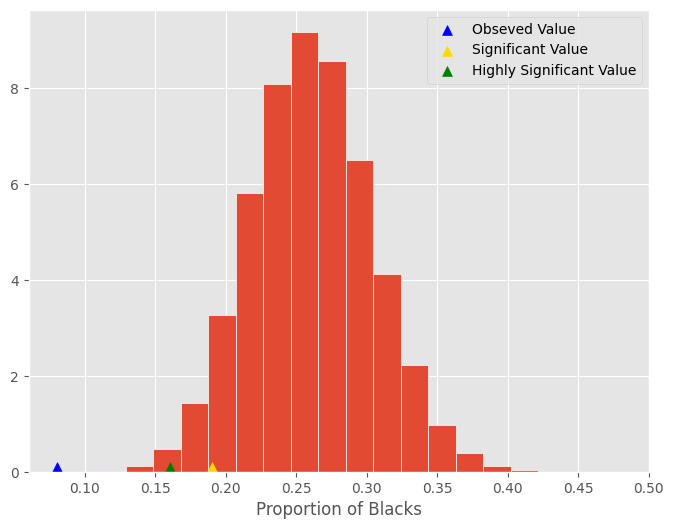

In [36]:
# distribution
plt.hist(props100K, density=True, ec="white", bins=20)

# observed value
plt.scatter(observed_prop, 0, c="blue", marker="^", s=200, label="Obseved Value")  # observed value

# significant value
plt.scatter(significant, 0, c="gold", marker="^", s=200, label="Significant Value")

# highly significant value
plt.scatter(highly_significant, 0, c="green", marker="^", s=200, label="Highly Significant Value")

plt.xlabel("Proportion of Blacks")

plt.legend(markerscale=0.5);

## Comments, Suggestions, Corrections

Please send your comments, suggestions, and corrections to lfinotti@utk.edu.